In [1]:
from IPython.display import display, HTML #make wider
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.lines as mlines
import os

In [3]:
# Local Functions

In [4]:
def drop_irrelevant_rows(sub_data):
    sub_data = sub_data.dropna(subset=['UNI_PRES'])
    return sub_data

def apply_year_filter(sub_data, s_yr, e_yr):
    sub_data['YEAR'] = pd.to_datetime(sub_data['ISO_TIME']).dt.year
    return sub_data[(sub_data['YEAR'] >= s_yr) & (sub_data['YEAR'] <= e_yr)]

###############################################################################################

def  drop_short_lived(sub_data,mstep):
    # Create a list to store storm data temporarily
    storm_data_temp = []

    for storm_id, storm_d in sub_data.groupby('SID'):
        if len(storm_d) >= mstep:
            storm_data_temp.append(storm_d)

    # Concatenate the list of DataFrames into a new DataFrame
    return pd.concat(storm_data_temp)        
       
def process_data(sub_data, mstep):
    return drop_short_lived(sub_data, mstep)

def plot_scatter_and_fit(sub_data, title, color, alpha=0.2, ax=None, draw='SnF'):
    pres_fit = np.array(sub_data['UNI_PRES'])
    wind_fit = np.array(sub_data['UNI_WIND'])
    cof = np.polyfit(pres_fit, wind_fit, 1)
    p = np.poly1d(cof)
    print(cof)

    if ax is None:
        ax = plt.gca()
        
    if draw=='SnF':
        ax.scatter(sub_data['UNI_PRES'], sub_data['UNI_WIND'], s=15, alpha=alpha, linewidths=0, label=title, color=color)
        ax.plot(pres_fit, p(pres_fit), lw=1.5, color=color)
    elif draw=='S':
        ax.scatter(sub_data['UNI_PRES'], sub_data['UNI_WIND'], s=15, alpha=alpha, linewidths=0, label=title, color=color)
    elif draw=='F':
        ax.plot(pres_fit, p(pres_fit), lw=1.5, color=color)
        
    ax.set_xlabel('Pressure (hPa)', fontsize=12)
    #ax.set_ylabel('Wind speed (m/s)', fontsize=12)
    del alpha
    
##############################################################################################

def point_in_polygon(lon, lat, polygon_path):
    return polygon_path.contains_point((lon, lat))

def basin_data(in_df, basin=None):
    
    # Read the dataframe
    df = in_df
    
    # Convert longitude values from [0, 360) to [-180, 180)
    df['LON'] = (df['LON'] + 180) % 360 - 180

    # Check if basin is provided
    if basin is not None:
        # Define the polygon coordinates based on the provided basin
        
        if basin == 'Glb':
            polygon_coords = np.array([[-180, 50], [-180, -50], [180, -50], [180, 50], [-180, 50]])
            
        elif basin == 'NA':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [0, 50], [0, 0], [-70, 0]])
            
        elif basin == 'EP':
            polygon_coords = np.array([[-70, 0], [-100, 20], [-100, 50], [-180, 50], [-180, 0], [-70, 0]])            
            
        elif basin == 'WNP': 
            polygon_coords = np.array([[100, 0], [100, 50], [180, 50], [180, 0], [100, 0]]) 
            
        elif basin == 'NI': 
            polygon_coords = np.array([[30, 0], [30, 50], [100, 50], [100, 0], [30, 0]]) 

        elif basin == 'SI': 
            polygon_coords = np.array([[10, 0], [10, -50], [135, -50], [135, 0], [10, 0]])            

        elif basin == 'SA': 
            polygon_coords = np.array([[10, 0], [10, -50], [-70, -50], [-70, 0], [10, 0]]) 

        elif basin == 'SP':  # this is special case. So, coordinate in 0 to 360 form
            polygon_coords = np.array([[135, 0], [135, -50], [290, -50], [290, 0], [135, 0]]) 

        # Create the polygon path
        polygon_path = Path(polygon_coords)

        # Filter rows based on the condition      
        if basin == 'SP':
            
            # Convert longitude values from [-180, 180] to [0, 360] before applying mask
            df['LON'] = (df['LON'] + 360) % 360 
            
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
    
            # Convert longitude values from back to [-180, 180]
            filtered_df['LON'] = (filtered_df['LON'] + 180) % 360 - 180
            
        else:
            mask = df.apply(lambda row: point_in_polygon(row['LON'], row['LAT'], polygon_path), axis=1)
            filtered_df = df[mask]
            
        return filtered_df
    # If basin is not provided, return the original DataFrame
    return df

In [5]:
# Main execution

/tmp/ipykernel_1761/2184109017.py:11: DtypeWarning: Columns (21,66,128,143) have mixed types. Specify dtype option on import or set low_memory=False.
  sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')


[-5.47917104e-01  5.70165174e+02]
[-3.35865094e-01  3.56730393e+02]
[-3.35865094e-01  3.56730393e+02]
[-4.49574943e-01  4.70122666e+02]
[-4.40655362e-01  4.62353056e+02]
[-5.47917104e-01  5.70165174e+02]
[-4.49574943e-01  4.70122666e+02]
[-3.35865094e-01  3.56730393e+02]
[-4.49574943e-01  4.70122666e+02]
[-4.40655362e-01  4.62353056e+02]
[-5.47917104e-01  5.70165174e+02]
[-4.40655362e-01  4.62353056e+02]
[-3.35865094e-01  3.56730393e+02]
[-4.49574943e-01  4.70122666e+02]
[-4.40655362e-01  4.62353056e+02]
Figure saved as: ../Figure/S2_Wind-Pressure Relationship (Resolution-Independent Criterion).pdf


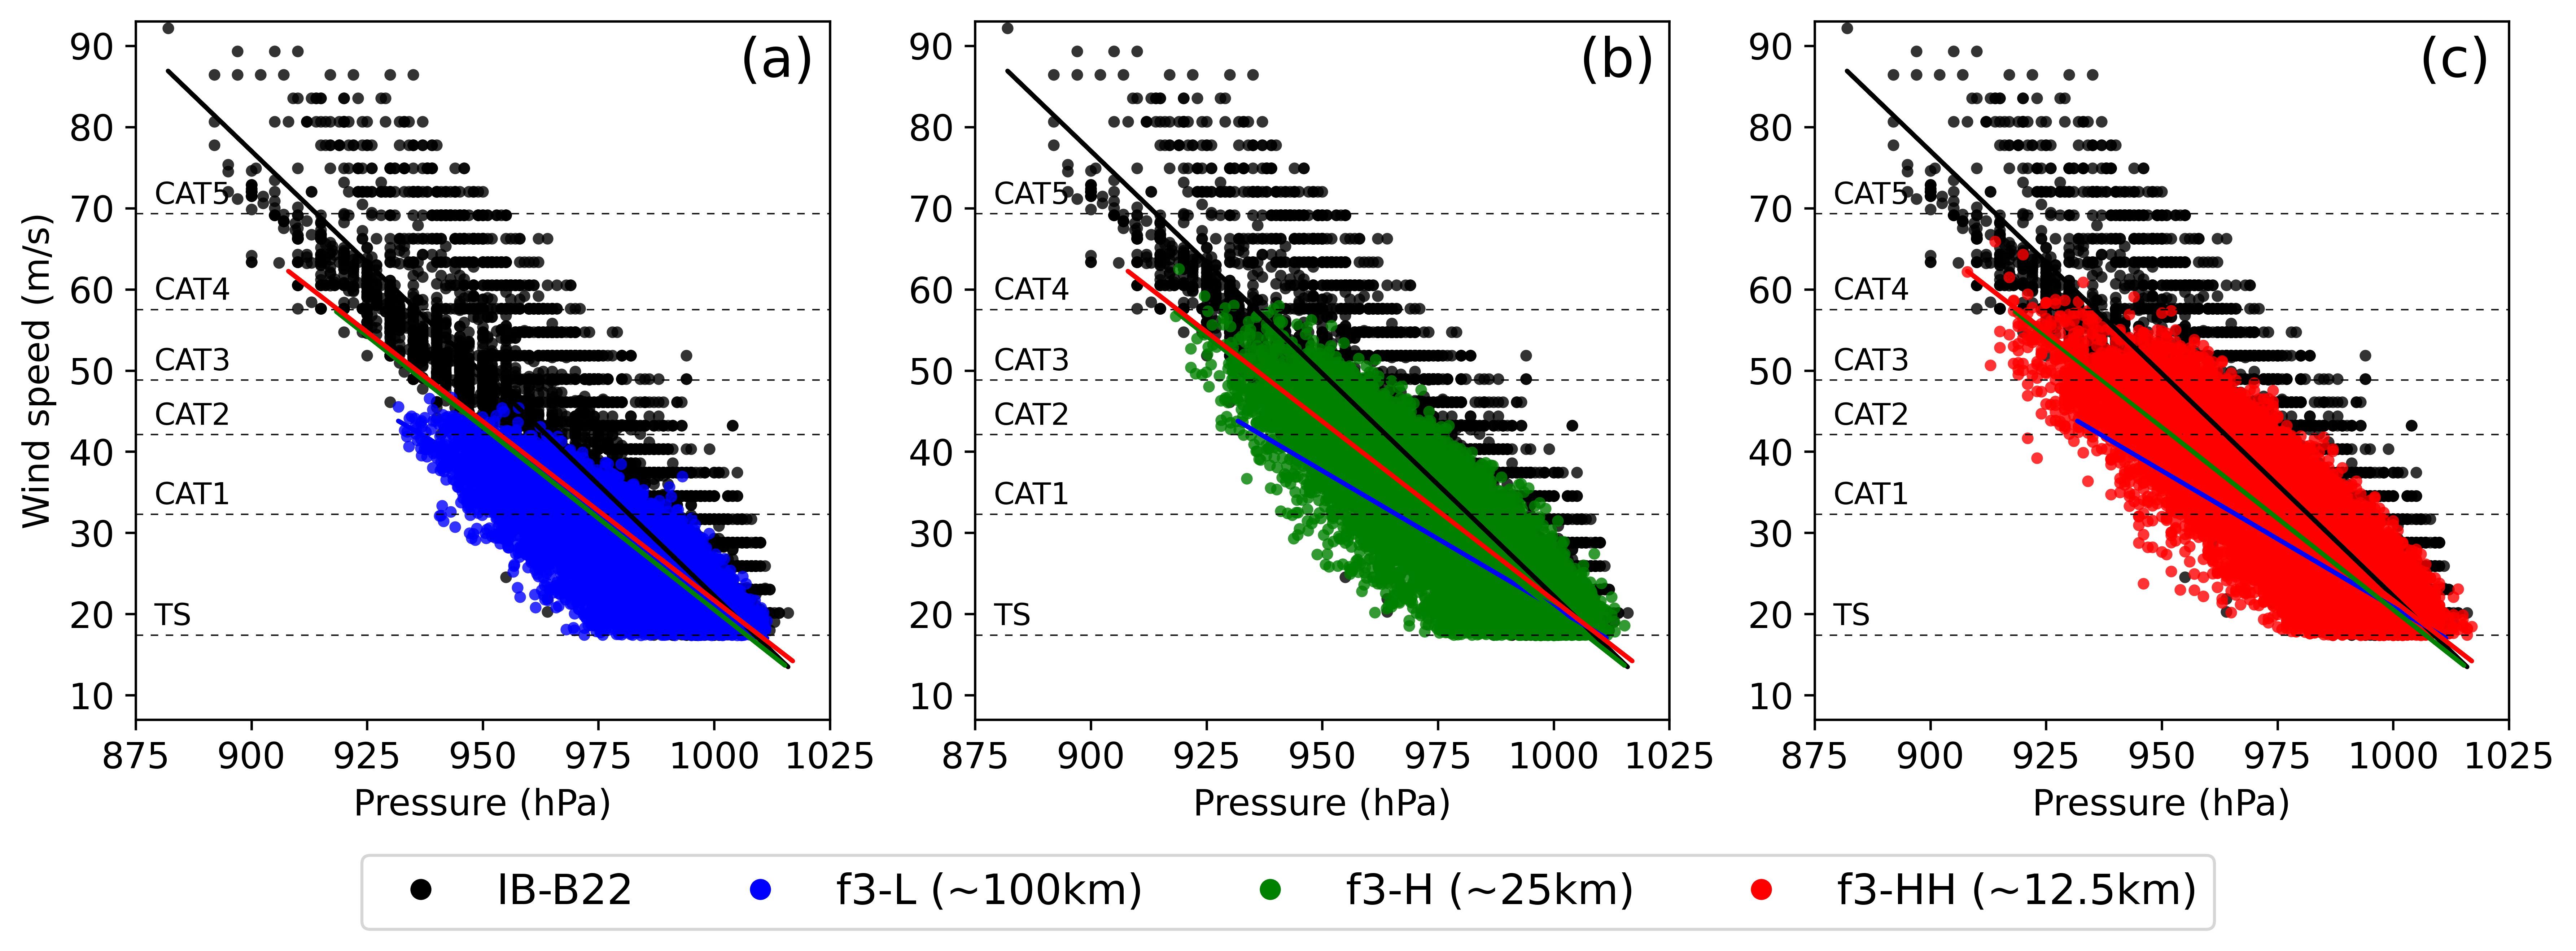

In [15]:
# Load your dataset with exp. settings
s_yr, e_yr = 1998, 2007

# Define the step threshold
mstep_ob = 4   # 1-day criteria for the observations (Bourdin et al, 2022)
mstep_mo = 12  # 3-day criteria for the model (Li et al, 2021)

basin = 'Glb'

# load_data
sub_data_1 = pd.read_csv('../Data/IBTrACS_[Bourdin2022].csv')
# Remove rows with missing pressure values from the best track records.
sub_data_1 = drop_irrelevant_rows(sub_data_1)

sub_data_2 = pd.read_csv('../Data/S_f3L_w17.4.csv')
sub_data_3 = pd.read_csv('../Data/S_f3H_w17.4.csv')
sub_data_4 = pd.read_csv('../Data/S_f3HH_w17.4.csv')

sub_data_1 = apply_year_filter(sub_data_1, s_yr, e_yr)
sub_data_2 = apply_year_filter(sub_data_2, s_yr, e_yr)
sub_data_3 = apply_year_filter(sub_data_3, s_yr, e_yr)
sub_data_4 = apply_year_filter(sub_data_4, s_yr, e_yr)

sub_data_1 = process_data(sub_data_1, mstep_ob)
sub_data_2 = process_data(sub_data_2, mstep_mo)
sub_data_3 = process_data(sub_data_3, mstep_mo)
sub_data_4 = process_data(sub_data_4, mstep_mo)

sub_data_1 = basin_data(sub_data_1, basin)
sub_data_2 = basin_data(sub_data_2, basin)
sub_data_3 = basin_data(sub_data_3, basin)
sub_data_4 = basin_data(sub_data_4, basin)


# Data sources to loop over
sources = [sub_data_2, sub_data_3, sub_data_4]
exp_names = ['f3-L (~100km)', 'f3-H (~25km)', 'f3-HH (~12.5km)']
colors = ['b', 'g', 'r']
labels = ['(a)', '(b)', '(c)']

# Create a 2x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=4.5, h_pad=5.0)  # Adjust the h_pad value to increase the vertical gap
fig.set_dpi(600)

for idx, (source, exp_name, color, label) in enumerate(zip(sources, exp_names, colors, labels)):
    
    ax = axes[idx]

    plot_scatter_and_fit(sub_data_1, 'IBTrACS', 'k', alpha=0.8, ax=ax) 
    plot_scatter_and_fit(source, exp_name, color, alpha=0.8, ax=ax)  # Default alpha
    
    plot_scatter_and_fit(sub_data_2, 'f3-L (~100km)', 'b', ax=ax, draw='F')  # Default alpha, Draw only the fitted line
    plot_scatter_and_fit(sub_data_3, 'f3-H (~25km)', 'g', ax=ax, draw='F')   # Default alpha, Draw only the fitted line   
    plot_scatter_and_fit(sub_data_4, 'f3-HH (~12.5km)', 'r', ax=ax, draw='F')  # Default alpha, Draw only the fitted line
    
    # --- horizontal dashed lines for TC categories ---
    cat_winds = [17.4, 32.3, 42.1, 48.8, 57.5, 69.3]
    cat_labels = ['TS', 'CAT1', 'CAT2', 'CAT3', 'CAT4', 'CAT5']
    for w, lab in zip(cat_winds, cat_labels):
        ax.axhline(y=w, color='black', linestyle='--', dashes=(5, 5),
                   linewidth=0.5, zorder=1, alpha=0.9)
        if idx != 99: 
            ax.text(879, w + 0.5, lab, color='black', fontsize=10, verticalalignment='bottom', horizontalalignment='left')      

    ax.set_xlim(875, 1025)
    ax.set_ylim(7, 93)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(12)
    
    if idx == 0: ax.set_ylabel('Wind speed (m/s)', fontsize=12)
    #ax.set_title(f'{label}', loc='left', fontsize=18)
    
    # Add (a), (b), (c) labels at top right inside subplot
    ax.text(0.87, 0.98, label, transform=ax.transAxes, 
            fontsize=18, fontweight='regular', va='top', ha='left')
    
# Create manual legend with circles
legend_elements = [
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='black', markersize=8, label='IB-B22'),
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='blue', markersize=8, label='f3-L (~100km)'),
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='green', markersize=8, label='f3-H (~25km)'),
    mlines.Line2D([0], [0], marker='o', color='w', 
                  markerfacecolor='red', markersize=8, label='f3-HH (~12.5km)')
]   

# Place legend in upper right corner of the figure
#fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 0.93), frameon=True, fontsize=14)

# Place horizontal legend below the figure
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.11), frameon=True, fontsize=14,
          ncol=4)  # This makes the legend horizontal

# Adjust layout to make space for the legend
plt.tight_layout()    

# Save the figure
os.makedirs('../Figure', exist_ok=True)
save_path = '../Figure/S2_Wind-Pressure Relationship (Resolution-Independent Criterion).pdf'
plt.savefig(save_path, dpi=600, bbox_inches='tight', format='pdf')
print(f"Figure saved as: {save_path}")    
    
plt.show()
